In [0]:
from google.colab import files
uploaded = files.upload()

Saving embeddings_words.csv to embeddings_words.csv


In [0]:
from google.colab import files
uploaded = files.upload()

Saving embeddings_vecs.csv to embeddings_vecs.csv


In [0]:
words = []
vectors = []

with open("embeddings_words.csv", 'r') as csvfile:
    read_words = csv.reader(csvfile)
    for row in read_words:
        words.append(row[0])

with open("embeddings_vecs.csv", 'r') as csvfile:
    read_vectors = csv.reader(csvfile)
    for row in read_vectors:
        row[0] = row[0].replace('\t', ' ')
        row[0] = list(row[0].split(' '))
        vectors.append(row[0])

print(len(words))
print(len(vectors))
print(vectors[0])

9999
9999
['-0.3725436', '-0.14344682', '-0.17298868', '-0.11457957', '-0.52645', '-0.058799755', '-0.12563413', '-0.0010286967', '0.362257', '0.09688376', '-0.03692043', '0.0741288', '-0.12001923', '0.06401264', '-0.020163264', '0.2163604']


In [0]:
embedding_index = {}
for i in range(len(words)):
    embedding_index[words[i]] = vectors[i]

print(len(embedding_index))

9999


In [0]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [0]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

training_sentences = training_sentences[0:1000]
testing_sentences = testing_sentences[0:1000]
training_labels_final = np.array(training_labels[0:1000])
testing_labels_final = np.array(testing_labels[0:1000])

print(len(training_sentences))

1000


In [0]:
vocab_size = 20000
embedding_dim = 128
max_length = 16
trunc_type='post'
oov_tok = "<OOV>"

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

sequences = tokenizer.texts_to_sequences(testing_sentences)
padded_test = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

print(word_index.items())
print(len(word_index))
print(padded_test.shape)
print(padded[0])
print(testing_labels_final.shape)

dict_items([('<OOV>', 1), ('the', 2), ('a', 3), ('and', 4), ('of', 5), ('to', 6), ('is', 7), ('br', 8), ('in', 9), ('it', 10), ('i', 11), ('this', 12), ('that', 13), ('was', 14), ('but', 15), ('as', 16), ('movie', 17), ('with', 18), ('for', 19), ('film', 20), ("'s", 21), ('you', 22), ('on', 23), ('are', 24), ('not', 25), ('his', 26), ('be', 27), ('one', 28), ('have', 29), ('he', 30), ('all', 31), ('they', 32), ('at', 33), ('by', 34), ('who', 35), ('an', 36), ('like', 37), ("'t", 38), ('so', 39), ('from', 40), ('her', 41), ('or', 42), ('just', 43), ("'", 44), ('there', 45), ('out', 46), ('if', 47), ('about', 48), ('has', 49), ('what', 50), ('some', 51), ('good', 52), ('when', 53), ('more', 54), ('no', 55), ('very', 56), ('up', 57), ('my', 58), ('can', 59), ('she', 60), ('b', 61), ('which', 62), ('time', 63), ('even', 64), ('would', 65), ('me', 66), ('their', 67), ('really', 68), ('story', 69), ('had', 70), ('see', 71), ('were', 72), ('well', 73), ('than', 74), ('only', 75), ('great', 76

In [0]:
embedding_matrix = np.zeros((vocab_size, 16))
for word, i in word_index.items():
	embedding_vector = embedding_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(20000, 16)


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, weights=[embedding_matrix], input_length=16, trainable=False),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(padded, training_labels_final, epochs=100, verbose=2, validation_data = (padded_test, testing_labels_final))
loss, accuracy = model.evaluate(padded, training_labels_final, verbose=2)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 16, 16)            320000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_86 (Dense)             (None, 6)                 774       
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 7         
Total params: 395,021
Trainable params: 75,021
Non-trainable params: 320,000
_________________________________________________________________
Epoch 1/100
32/32 - 1s - loss: 0.6915 - accuracy: 0.5270 - val_loss: 0.6894 - val_accuracy: 0.5420
Epoch 2/100
32/32 - 0s - loss: 0.6863 - accuracy: 0.5440 - val_loss: 0.6874 - val_accuracy: 0.5460
Epoch 3/100
32/32 - 0s - loss: 0.6778 - ac

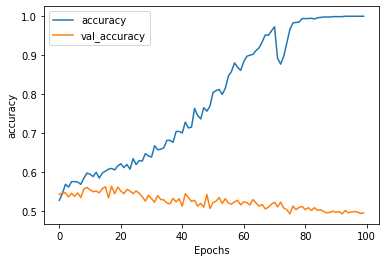

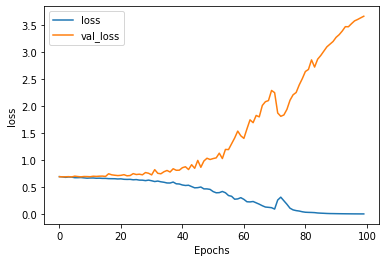

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")